In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow_probability.substrates import numpy as tfp

In [2]:
from cmdstanpy import CmdStanModel, set_cmdstan_path
import arviz as az

In [3]:
X = pd.read_csv("../Datasets/covariates.csv")

In [4]:
#Change 120 with 180 at needed
Y = pd.read_csv("../Datasets/Dataset_120.csv")
Y['Count_120'] = pd.to_numeric(Y['Count_120']).astype('Int64')

In [5]:
X = pd.get_dummies(X ,columns = ['Type'] ,prefix = 'type', drop_first = True)

In [6]:
X.loc[X['Station'] == 10171, 'Quota'] = 10

In [7]:
rows_to_drop_Y = Y[Y['Count_120'].isna()].index

# Remove corresponding rows from dataset X
X = X.drop(index=rows_to_drop_Y)
Y = Y.drop(index=rows_to_drop_Y)

# If you want to reset the index after dropping rows
X = X.reset_index(drop=True)
Y = Y.reset_index(drop=True)

In [8]:
stations = X['Station']
years = X['Year'] - 2009
unique_values = sorted(set(stations))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
transformed_stations = [mapping_dict[value] for value in stations]
stations = transformed_stations

In [9]:
len(stations)

3840

In [10]:
X = X.drop(['Year','Station','Month'], axis  = 1)

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std = pd.DataFrame(X_std, columns=X.columns)

In [12]:
base_model = """

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number
  int<lower=1> nyears;
  int<lower=1> nstations;


  array[N] int<lower=1> station;
  array[N] int<lower=1> year;
  // array[N] int<lower=4, upper=10> month;

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
}

parameters {
  vector[P] beta; // Coefficients for predictors
  vector[nstations] eta; // Random effects for comuni
  vector[nyears] xi; // Random effects for years

  //real<lower=0> sigma0; // Standard deviation for beta
  //real<lower=0> sigma1; // Standard deviation for xi
  //real<lower=0> sigma2; // Standard deviation for eta
}

transformed parameters {
    vector[N] lambda;
    vector[N] intercept;
    vector[N] fix_eff;

    intercept = xi[year] + eta[station];
    fix_eff = X * beta;

    lambda = exp(intercept + fix_eff);
}

model {

  beta ~ normal(0, 2);
  xi ~ normal(0, 2);
  eta ~ normal(0, 2);
  y[1:N] ~ poisson(lambda[1:N]);


}
generated quantities{
 vector[N] log_lik;
 for(i in 1:N){
   log_lik [ i ] = poisson_lpmf (y [ i ] |lambda[i]) ;
}
}

"""

stan_file = "./base.stan"

with open(stan_file, "w") as f:
    print(base_model, file=f)

model_base = CmdStanModel(stan_file=stan_file)

12:09:41 - cmdstanpy - INFO - compiling stan file C:\Users\leoma\OneDrive\DOCUME~1\PoliMi\BAYESI~1\BAYESI~1\main\Modello\base.stan to exe file C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\base.exe
12:10:14 - cmdstanpy - INFO - compiled model executable: C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\base.exe


In [13]:
data = {
    "N": len(Y),
    "P": X_std.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": stations,
    "year": years,
    "y": Y['Count_120'],
    "X": X_std
}


fit = model_base.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_az = az.from_cmdstanpy(fit)

12:10:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:13:22 - cmdstanpy - INFO - CmdStan done processing.


12:13:23 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 37 iterations at max treedepth (18.5%)
	Chain 2 had 84 iterations at max treedepth (42.0%)
	Chain 3 had 39 iterations at max treedepth (19.5%)
	Chain 4 had 101 iterations at max treedepth (50.5%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


C:\Users\leoma\anaconda3\Lib\site-packages\arviz\plots\traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (45), generating only 20 plots
  warnings.warn(


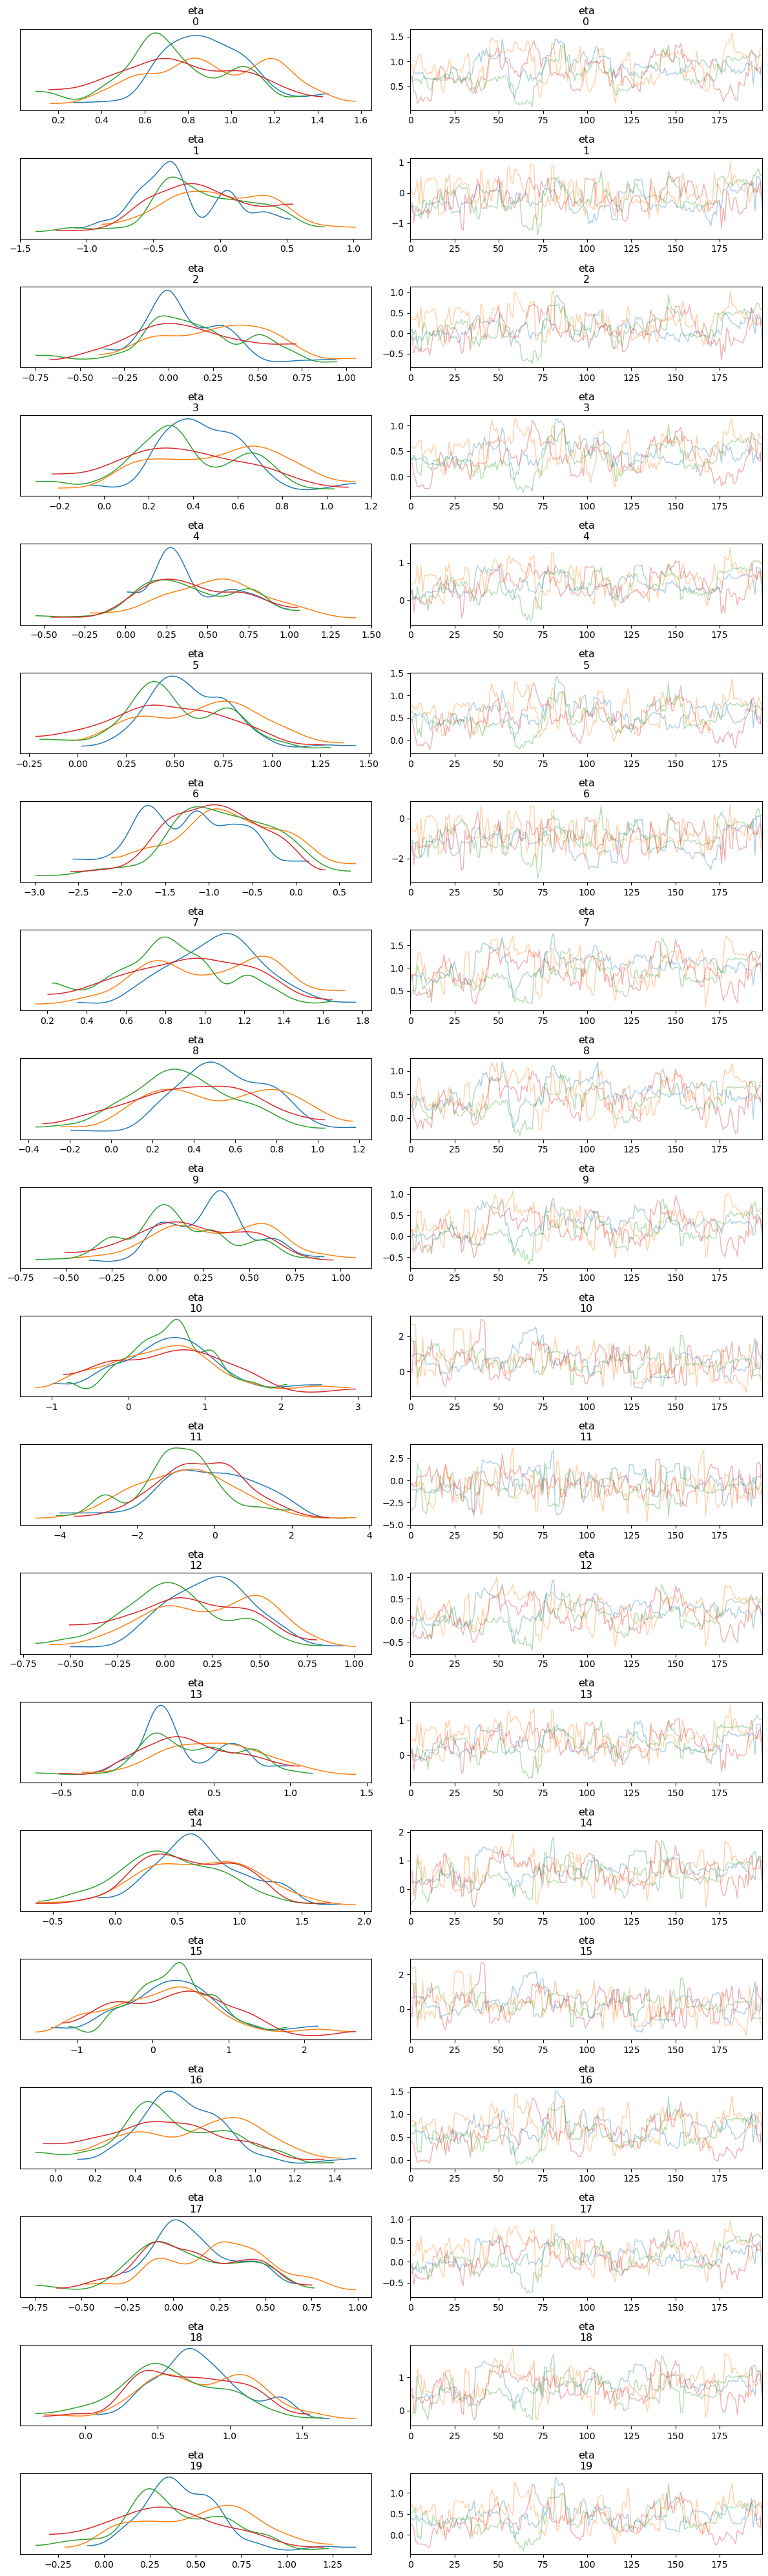

In [14]:
az.plot_trace(posterior_az, var_names = ['eta'], compact=False)
plt.tight_layout()
plt.show()

In [39]:
# Calcola e stampa WAIC
waic_result = az.waic(fit, var_name="log_lik")
print("WAIC: ", waic_result)

# Calcola e stampa LOO
loo_result = az.loo(fit, var_name="log_lik")
print("LOO: ", loo_result)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC:  Computed from 800 posterior samples and 3840 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -10099.80    86.22
p_waic      104.44        -

There has been a warning during the calculation. Please check the results.
LOO:  Computed from 800 posterior samples and 3840 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -10100.48    86.23
p_loo      105.12        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3840  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [43]:
az.compare({"Mod1": fit, "Mod2": fit})

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Mod1,0,-10100.480274,105.119034,0.0,0.5,86.227759,0.0,False,log
Mod2,1,-10100.480274,105.119034,0.0,0.5,86.227759,0.0,False,log
